Initialized Delivery Environment with points from generated_points.csv
Target metric for optimization is distance


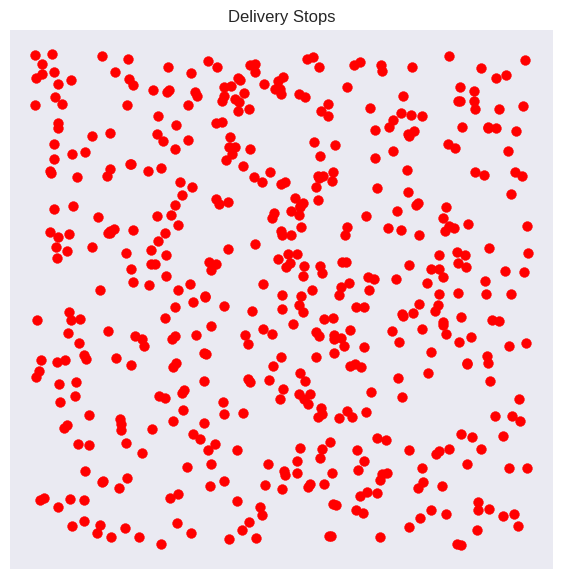

<ipython-input-3-c6978a847742>:387: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/1000 [00:00<?, ?it/s]

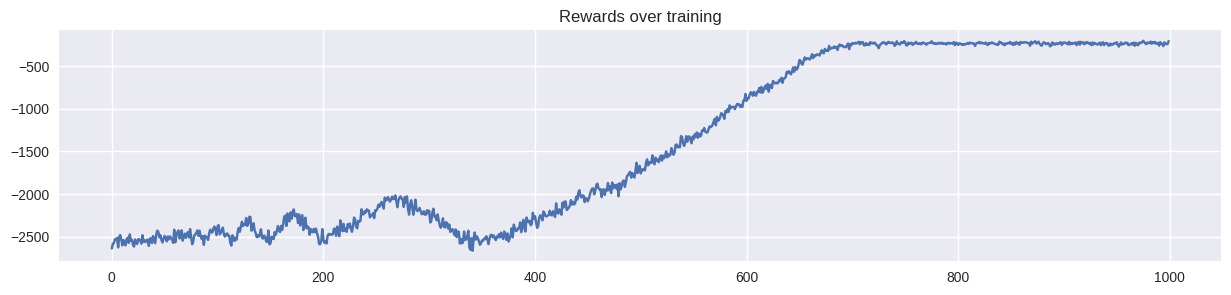

(<__main__.DeliveryEnvironment at 0x7d016e250730>,
 <__main__.DeliveryQAgent at 0x7d016e2504f0>)

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-v0_8")
import sys
sys.path.append("../")

# Work done by Manoj and Avinash
class Agent(object):
    def __init__(self):
        pass

    def expand_state_vector(self, state):
        if len(state.shape) == 1 or len(state.shape) == 3:
            return np.expand_dims(state, axis=0)
        else:
            return state

    def remember(self, *args):
        self.memory.save(args)


class QAgent(Agent):
    def __init__(self, states_size, actions_size, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999, gamma=0.95, lr=0.8):
        self.states_size = states_size
        self.actions_size = actions_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.lr = lr
        self.Q = self.build_model(states_size, actions_size)

    def build_model(self, states_size, actions_size):
        Q = np.zeros([states_size, actions_size])
        return Q

    def train(self, s, a, r, s_next):
        self.Q[s, a] = self.Q[s, a] + self.lr * (r + self.gamma * np.max(self.Q[s_next, a]) - self.Q[s, a])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, s):
        q = self.Q[s, :]

        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            a = np.random.randint(self.actions_size)

        return a


class DeliveryEnvironment(object):
    def __init__(self, points_csv="generated_points.csv", method="distance", **kwargs):
        print(f"Initialized Delivery Environment with points from {points_csv}")
        print(f"Target metric for optimization is {method}")

        # Load points from CSV file
        self.load_points_from_csv(points_csv)

        # Initialization
        self.n_stops = len(self.x)
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.max_box = kwargs.get('max_box', 10)
        self.stops = []
        self.method = method

        # Generate stops
        self._generate_constraints(**kwargs)
        self._generate_q_values()
        self.render()

        # Initialize first point
        self.reset()

    def load_points_from_csv(self, csv_file):
        points_df = pd.read_csv(csv_file)
        self.x = points_df['X'].values
        self.y = points_df['Y'].values

    def _generate_constraints(self, box_size=0.2, traffic_intensity=5):
        if self.method == "traffic_box":
            x_left = np.random.rand() * (self.max_box) * (1 - box_size)
            y_bottom = np.random.rand() * (self.max_box) * (1 - box_size)

            x_right = x_left + np.random.rand() * box_size * self.max_box
            y_top = y_bottom + np.random.rand() * box_size * self.max_box

            self.box = (x_left, x_right, y_bottom, y_top)
            self.traffic_intensity = traffic_intensity

    def _generate_q_values(self, box_size=0.2):
        if self.method in ["distance", "traffic_box"]:
            xy = np.column_stack([self.x, self.y])
            self.q_stops = cdist(xy, xy)
        elif self.method == "time":
            self.q_stops = np.random.rand(self.n_stops, self.n_stops) * self.max_box
            np.fill_diagonal(self.q_stops, 0)
        else:
            raise Exception("Method not recognized")


    def render(self,return_img = False):

        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Delivery Stops")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")

            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")


        if hasattr(self,"box"):
            left,bottom = self.box[0],self.box[2]
            width = self.box[1] - self.box[0]
            height = self.box[3] - self.box[2]
            rect = Rectangle((left,bottom), width, height)
            collection = PatchCollection([rect],facecolor = "red",alpha = 0.2)
            ax.add_collection(collection)


        plt.xticks([])
        plt.yticks([])

        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape((height, width, 4))
            plt.close(fig)
            return image
        else:
            plt.show()



    def reset(self):

        # Stops placeholder
        self.stops = []

        # Random first stop
        first_stop = np.random.randint(self.n_stops)
        self.stops.append(first_stop)

        return first_stop


    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination

        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,reward,done


    def _get_state(self):
        return self.stops[-1]


    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self,state,new_state):
        base_reward = self.q_stops[state,new_state]

        if self.method == "distance":
            return base_reward
        elif self.method == "time":
            return base_reward + np.random.randn()
        elif self.method == "traffic_box":

            # Additional reward correspond to slowing down in traffic
            xs,ys = self.x[state],self.y[state]
            xe,ye = self.x[new_state],self.y[new_state]
            intersections = self._calculate_box_intersection(xs,xe,ys,ye,self.box)
            if len(intersections) > 0:
                i1,i2 = intersections
                distance_traffic = np.sqrt((i2[1]-i1[1])**2 + (i2[0]-i1[0])**2)
                additional_reward = distance_traffic * self.traffic_intensity * np.random.rand()
            else:
                additional_reward = np.random.rand()

            return base_reward + additional_reward


    @staticmethod
    def _calculate_point(x1,x2,y1,y2,x = None,y = None):

        if y1 == y2:
            return y1
        elif x1 == x2:
            return x1
        else:
            a = (y2-y1)/(x2-x1)
            b = y2 - a * x2

            if x is None:
                x = (y-b)/a
                return x
            elif y is None:
                y = a*x+b
                return y
            else:
                raise Exception("Provide x or y")


    def _is_in_box(self,x,y,box):
        # Get box coordinates
        x_left,x_right,y_bottom,y_top = box
        return x >= x_left and x <= x_right and y >= y_bottom and y <= y_top


    def _calculate_box_intersection(self,x1,x2,y1,y2,box):

        # Get box coordinates
        x_left,x_right,y_bottom,y_top = box

        # Intersections
        intersections = []

        # Top intersection
        i_top = self._calculate_point(x1,x2,y1,y2,y=y_top)
        if i_top > x_left and i_top < x_right:
            intersections.append((i_top,y_top))

        # Bottom intersection
        i_bottom = self._calculate_point(x1,x2,y1,y2,y=y_bottom)
        if i_bottom > x_left and i_bottom < x_right:
            intersections.append((i_bottom,y_bottom))

        # Left intersection
        i_left = self._calculate_point(x1,x2,y1,y2,x=x_left)
        if i_left > y_bottom and i_left < y_top:
            intersections.append((x_left,i_left))

        # Right intersection
        i_right = self._calculate_point(x1,x2,y1,y2,x=x_right)
        if i_right > y_bottom and i_right < y_top:
            intersections.append((x_right,i_right))

        return intersections


class DeliveryQAgent(QAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reset_memory()

    def act(self, s):
        q = np.copy(self.Q[s, :])
        q[self.states_memory] = -np.inf

        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])

        return a

    def remember_state(self, s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []


def run_episode(env, agent, verbose=1):
    s = env.reset()
    agent.reset_memory()

    max_step = env.n_stops
    episode_reward = 0

    i = 0
    while i < max_step:
        agent.remember_state(s)
        a = agent.act(s)
        s_next, r, done = env.step(a)
        r = -1 * r

        if verbose:
            print(s_next, r, done)

        agent.train(s, a, r, s_next)
        episode_reward += r
        s = s_next

        i += 1
        if done:
            break

    return env, agent, episode_reward




# GIF generation to show the work of RL finding path
def run_n_episodes(env, agent, name="training.gif", n_episodes=1000, render_each=10, fps=10):
    rewards = []
    imgs = []

    for i in tqdm_notebook(range(n_episodes)):
        env, agent, episode_reward = run_episode(env, agent, verbose=0)
        rewards.append(episode_reward)

        if i % render_each == 0:
            img = env.render(return_img=True)
            imgs.append(img)

    plt.figure(figsize=(15, 3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()

    imageio.mimsave(name, imgs, duration=100)

    return env, agent


# Specify the CSV file containing the points
points_csv_file = "generated_points.csv"

env = DeliveryEnvironment(points_csv=points_csv_file, method="distance")
agent = DeliveryQAgent(env.observation_space, env.action_space)
run_n_episodes(env, agent, "training.gif")
